In [12]:
import re
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path
from pprint import pprint

from collections import Counter
from collections import defaultdict

# from jupyter_client import kernelspec
# spec = kernelspec.get_kernel_spec(kernel_name="PyTorch-2.0.1")
# print(spec.resource_dir)


In [13]:
def get_run_files(root="/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs"):
    # return [x for x in Path(root).glob("**/*.0") if x.suffix == ".0"]
    return [x for x in Path(root).glob("**/version_0/*.0") if x.suffix == ".0"]

def get_scalar_run_tensorboard(tag, filepath:str):
    values,steps = [],[]
    for e in tf.compat.v1.train.summary_iterator(filepath):
        if len(e.summary.value)>0: #Skip first empty element
            if e.summary.value[0].tag==tag:
                tensor = e.summary.value[0]
                value, step = (e.summary.value[0].simple_value, e.step)
                values.append(value)
                steps.append(step)
        # print (steps)
    return values, steps

def return_the_substring(text, keylist):
    for key in keylist:
        if key in text:
            return key
    return ""

def round_it(listofvalues, by=5):
    """Rounds each value in the list of values to the closest by."""
    return map(lambda x: x-x%by, listofvalues)

lr_pattern = re.compile(r'lr([0-9]*\.?[0-9]+)--')
def get_learningrate(files):
    """Extract the learning rate from the file name.
    
        ex: "...vit_l_16--lr0.00025--bs128...:
    
    """
    for file in files:
        match = lr_pattern.search(str(file))
        if match:
            yield match.group(1)

        
    
list_of_tags = ["train_f1_epoch", "val_f1_epoch"]
# list_of_tags = ["train_f1_epoch"]

In [14]:
f = '/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-19--lr0.00025--bs32--transformsEraseHFlip/version_0/events.out.tfevents.1695179531.c0906a-s35.ufhpc.761078.0'
# [ e.summary.value[0].tag for e in tf.compat.v1.train.summary_iterator(f) if e.summary.value ]

In [15]:
files = get_run_files()
# list(set(filter(lr_pattern.search, map(str, files))))
# list(map(lambda x: x.absolute, files))
# str(files[0].absolute())
set(get_learningrate(files))

{'0.0001', '0.00025'}

In [16]:
def generate_plot():
    files = get_run_files()
    lrs = list(set(get_learningrate(files)))
    tags = list_of_tags
    print(tags)
    
    # Grab tags from the tensorboard log files
    for tag in tags:
        lr = {}
        for rate in lrs:
            lr[rate] = { "steps": [], "values": [] }
            
        for file in map(str,files):
            values, steps = get_scalar_run_tensorboard(tag, file)
            steps = round_it(steps, 50)

            for key in lr.keys():
                if return_the_substring(file, list(key)):
                    lr.get(key)["steps"].extend(steps)
                    lr.get(key)["values"].extend(values)
    
        # Get mean and stddev for each step in lr2
        lr2 = {}
        for i, (k,data) in enumerate(lr.items()):
            d = defaultdict(list)
            for (step, value) in zip(data["steps"], data["values"]):
                d[step].append(value)
            # Get avg and stddev of each step
            d2 = {}
            for (step, vals) in d.items():
                d2[step] = {"avg": np.average(vals), "std": np.std(vals) }
            lr2[k] = d2
        
        import pprint 
        # pprint.pprint(lr2["0.001"])
        
        plt.figure()

        handlekeys = [] # Used for legend
        for key, data in lr2.items():
            # e.g. key = "0.01", data = {step: { avg, std } }
            print(f"key: {key}") 
            if key == "0.0001": continue

            datakeys = list(data.keys())
            averages = list(map(lambda x: x["avg"], list(data.values())))
            upperbound = list(map(lambda x: x["avg"] + x["std"], list(data.values())))
            lowerbound = list(map(lambda x: x["avg"] - x["std"], list(data.values())))

            handle, = plt.plot(datakeys, averages, linewidth=1, label=key)
            handlekeys.append(handle)
            plt.fill_between(datakeys, upperbound, lowerbound, alpha=.5, linewidth=0)   

        # plt.legend(lr.keys(), loc="lower right")
        plt.legend(handles=handlekeys, loc="lower right")
        plt.xlabel("steps")
        plt.ylabel(tag)

        #print(f'{sorted(Counter(lr["0.01"]["steps"]).items())}')


['train_f1_epoch', 'val_f1_epoch']
key: 0.00025
key: 0.0001
key: 0.00025
key: 0.0001


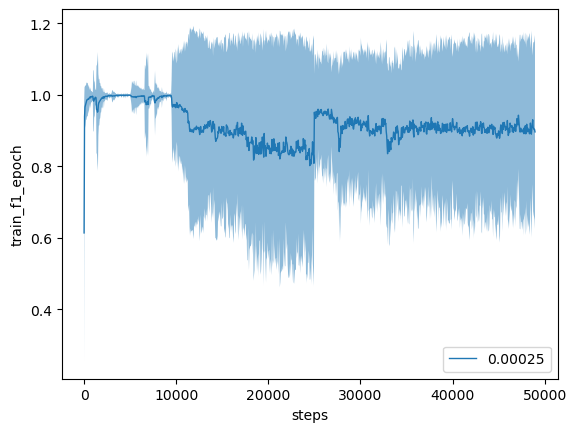

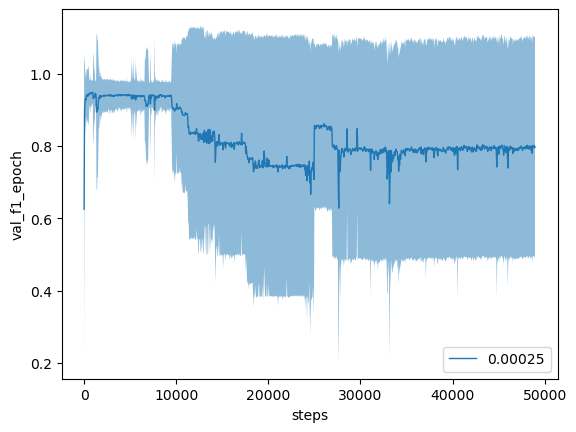

In [17]:
# NotebookApp.iopub_data_rate_limit=10000000.0
generate_plot()

In [18]:
# List all the files
get_run_files()

[PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-19--lr0.00025--bs32--transformsEraseHFlip/version_0/events.out.tfevents.1695179531.c0906a-s35.ufhpc.761078.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-19--lr0.0001--bs128--transformsErase/version_0/events.out.tfevents.1695179528.c0803a-s29.ufhpc.1785741.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-20--vit_l_16--lr0.00025--bs128--transformsErase/version_0/events.out.tfevents.1695260086.c0801a-s11.ufhpc.996408.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-20--vit_l_16--lr0.00025--bs64--transformsErase/version_0/events.out.tfevents.1695260257.c0800a-s23.ufhpc.1395049.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs/2023-09-20--lr0.00025--bs16--transformsNone/version_0/events.out.tfevents.1695187032.c0800a-s35.ufhpc.126813.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixtecla